# Photonic integrated circuit: ring resonator

## Overview
We simulate small silicon ring resonator coupled to parallel waveguides buried in silica cladding. Compare with [Lumerical example](https://optics.ansys.com/hc/en-us/articles/360042800293-Ring-resonator-getting-started-Design-and-initial-simulation)

## Geometry

running luminescent python frontend


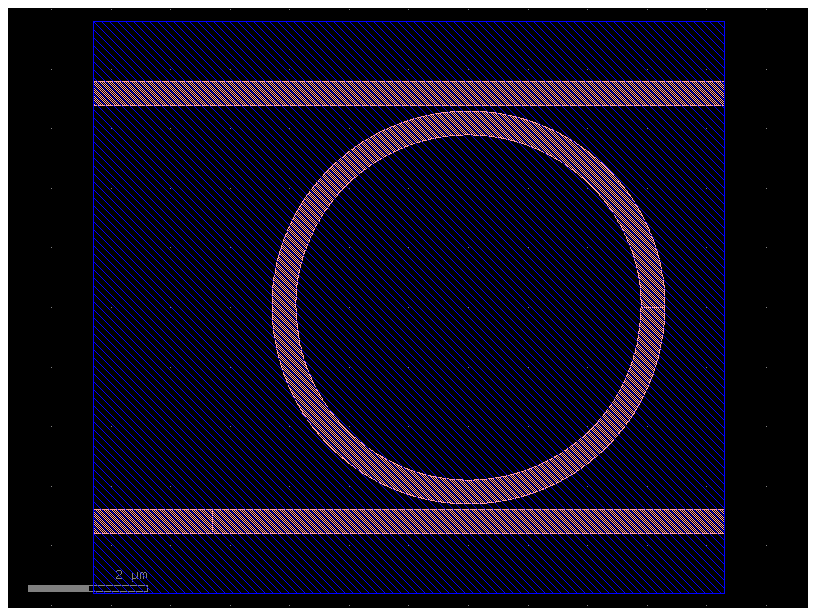

In [1]:
import luminescent as lumi
from gdsfactory.technology import LogicalLayer, LayerLevel, LayerStack
import gdsfactory as gf
import numpy as np
import os
import matplotlib.pyplot as plt

# simulation folder
path = os.path.join("runs", "ring")
name='photonic ring resonator'

# length units are arbitrary so long as they are consistent, in this case [um]. everything gets normalized around origin wavelength and period at backend.
wavelength = 1.55  # characteristic wavelength [um]
bandwidth = 0.1  # wavelength bandwidth [um]
wavelengths = np.linspace(wavelength - bandwidth / 2, wavelength + bandwidth / 2, 401)

r = 3.1  # radius of ring
w_wg = 0.4  # width of waveguide
gap = 0.1  # gap between waveguide and ring
th = 0.18  # th of waveguide

# gds layers
WG = (1, 0)  # waveguide layer
BBOX = (10, 0)  # bounding box layer

# we create geometry in gdsfactory. alternatively, you can import .gds layout into gdsfactory or .stl bodies directly into ours

# margins
height_port_margin = lateral_port_margin = 0.8
margin = 1.25 * lateral_port_margin
zmargin = 1.25 * height_port_margin
source_port_margin = 1.0 * (w_wg + 2 * lateral_port_margin)

# draw layout in gdsfactory. `gf.components` defaults to layer WG = (1, 0)
c = gf.Component()

dut = c << gf.components.ring(radius=r, width=w_wg, layer=WG)

l_branch = 2 * r + w_wg + source_port_margin + 2*margin
xoffset = -source_port_margin - margin - r - w_wg / 2
yoffset = w_wg + gap + r
branch_top = c << gf.components.straight(length=l_branch, width=w_wg)
branch_top.move((xoffset, w_wg + gap + r))

branch_bottom_left = c << gf.components.straight(length=source_port_margin, width=w_wg)
branch_bottom_left.move((xoffset, -yoffset))

branch_bottom_right = c << gf.components.straight(length=l_branch - source_port_margin, width=w_wg)
branch_bottom_right.connect("o1", branch_bottom_left.ports["o2"])


# add ports
c.add_port("o1", port=branch_bottom_right.ports["o1"])
c.add_port("o2", port=branch_bottom_right.ports["o2"])  # thru channel
c.add_port("o3", port=branch_top.ports["o1"])  # drop channel

c << gf.components.bbox(component=c, layer=BBOX, top=margin, bottom=margin)
c.plot()

## Solve

saving mode plots to runs\ring\modes\1
showing modes for first wavelength 
using simulation folder c:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\runs\ring
0.02767857142857143
0.02767857142857143
0.02767857142857143
0.02767857142857143
loading problem from C:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\runs\ring

can't find fdtd binary 


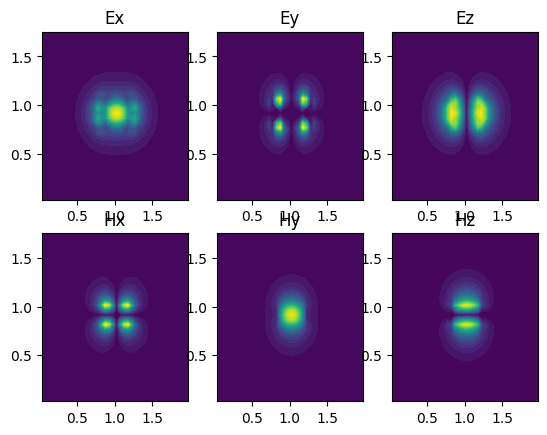

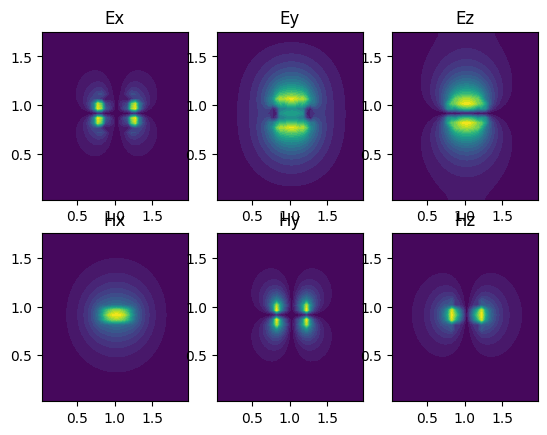

In [5]:
# for gdsfactory, we need vertical layer stack. "core" layer is special as `height_port_margin` are demarcated from it for defining modal sources and monitors. during 3d meshing lower mesh order layers supplant higher mesh order layers
layer_stack = LayerStack(
    layers={
        "core": LayerLevel(
            layer=LogicalLayer(layer=WG),
            thickness=th,
            zmin=0.0,
            material="Si",
            mesh_order=10,
        ),
    }
)

# our default lumi.MATERIALS_LIBRARY lib covers limited range of photonic and PCB materials_library. here we create our own materials_library. `background` is special and tags regions outside any bodies during meshing
materials_library = {
    "Si": lumi.Material(epsilon=12.25),
    "SiO2": lumi.Material(epsilon=2.25),
}
materials_library["background"] = materials_library[
    "SiO2"
]  

# source launches `source_port_margin` in front of port. it's bidirectional: the other direction goes into PML. pulse spectrum rolls off gradually past bandwidth limits.
sources = [
    lumi.Source(
        "o1",
        source_port_margin=source_port_margin,
        wavelength=wavelength,
        bandwidth=wavelength/5,
    )
]

lx=w_wg + 2 * lateral_port_margin
ly=th + 2 * height_port_margin
modes = [lumi.Mode(
    ports=[f'o{i}' for i in [1, 2, 3]], # ports that this mode applies to
    wavelengths=lumi.chebyshev_nodes(wavelengths[0], wavelengths[-1]),
    start=[-lx/2, -height_port_margin], # local xy frame, local y=0 at global zmin of port layer
    stop=[lx/2, th + height_port_margin],
    )]

lumi.make(
    path=path,
    component=c,
    wavelengths=wavelengths,
    sources=sources,
    modes=modes,
    # limits
    zmin=-zmargin,
    zmax=th + zmargin,
    # materials and layers
    materials_library=materials_library,
    layer_stack=layer_stack,
    # accuracy and speed settings
    gpu="CUDA",  # use GPU acceleration
    nres=8,  # number of grid points per wavelength in material (not vacuum)
    relative_courant=0.95,  # relative to maximum theoretical Courant number at
    relative_pml_depths=[1, 1, 0.3],  # relative PML thes
    Tsim=500,  # max time [periods]
    field_decay_threshold=0.01,  # field energy decay threshold for stopping simulation
    # visualization
    saveat=50,  # save and plot field every n periods
    views=[lumi.View("Hz", z="halfway", y=0, x=0)],
)

lumi.solve(path)

## Visualize


failed plotting new frames


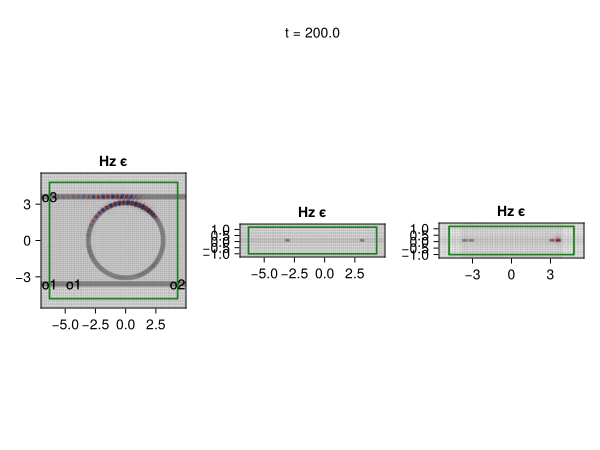

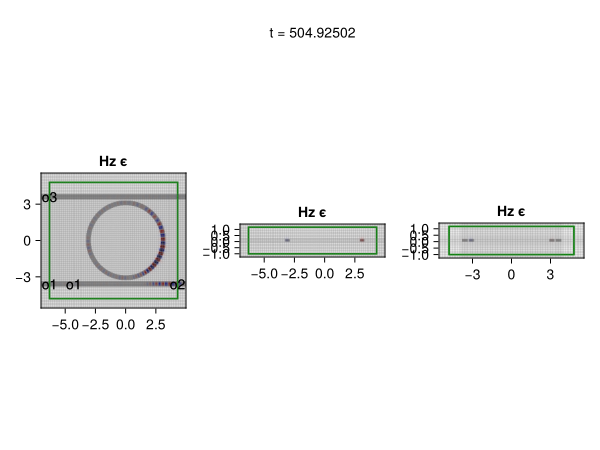

In [2]:
lumi.peek(path) # halfway and final snapshots


failed plotting new frames
Video generated successfully at c:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\runs\ring\simulation.gif!


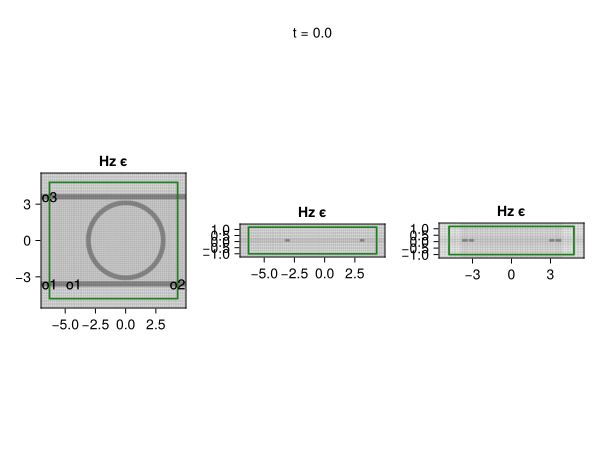

In [4]:
lumi.movie(path) # full movie - this may take a while to generate

## Analysis

loading solution from C:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\runs\ring


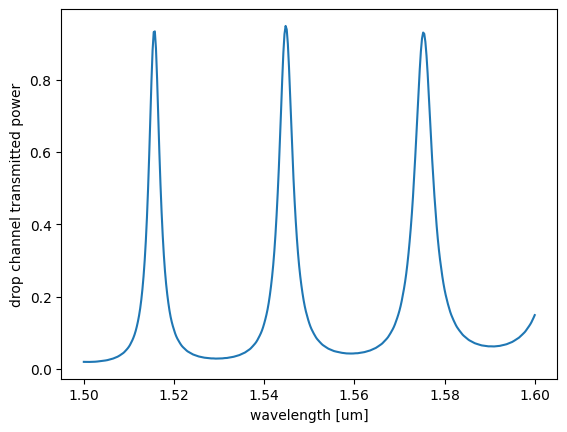

In [7]:
sol = lumi.load(path)
x = wavelengths

y = lumi.query(sol, "T3,1") # wavelength or frequency ordered depending on problem setup
# y=np.abs2(sol['waves']['o3@0']/sol['waves']['o1@0'])

plt.plot(x, y)
plt.xlabel("wavelength [um]")
plt.ylabel("drop channel transmitted power")
plt.show()